# **Sim-SOENs**
## ***A Simulator for Superconducting Optoelectronic Networks***

# Introduction: *What are SOENs?*
<!-- ![ title](img/wafer_tilted.png) ![ title](img/neuron_3d.png) ![ title](img/neuron_complex.png) -->
![ title](../img/wafers_3d_neuron.png)
 - SOENs are an emerging neuromorphic hardware that leverage light-speed communication for brain level scalability.
 - Instanstiate spiking neural networks
   - Spikes --> photons
   - Neurons --> superconducting circuits
   - Transmitters --> silicon diode light source
 - SOEN neurons are neuro-inspired, with sophisticated dendritic arbors for single-neuron computations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from sim_soens.super_input import SuperInput
from sim_soens.soen_sim import network
from sim_soens.super_node import SuperNode
from sim_soens.soen_plotting import raster_plot, activity_plot

## Part 1: What is a SOEN Neuron?

A SOEN Neuron consists of three main components:
 - **Synapse**     = Single Photon Detector (SPD)
 - **Dendrite**   = Superconducting Quantum Interference Device (SQUID) as the *recieving loop* with an L/R circuit *integration loop*
   - *Somatic Dendrite*
     - Acts as the cell-body
     - Integrates signal from a preceding dendritic arbor, or directly from a synapse
     - When threshold is reached, activates transmitter circuit and couples flux to refractory dendrite
   - *Refractory Dendrite*
     - inhibits somatic dendrite through coupled flux
   - *Arbor Dendrite*
     - An arbor can consist of arbirtrary multi-dendrite structures
     - All roads lead to soma
 - **Transmitter** = hTron coupled to a silicon light emitting diode which routes photonic output to downstream synapses via waveguides

![ title](../img/monosynaptic.png)

In Sim-SOENs, conjuring up a neuron is best done through the `SuperNode` class
 - A node is an object that contains all components of a neuron
 - It also hosts meta-data about the neuron
 - Finally, it hold post-simulation data about the neuron's activity

In [2]:
# instantiate an instance of the SuperNode class
# by default, contains minimal example of a neuron
# monosynaptic neuron w/ one somatic and one refractory dendrite 
node = SuperNode()
node.parameter_print()


SOMATIC DENDRITE:
 ib_n = 1.802395858835221
 tau_ni = 50
 beta_ni = 628.3185307179587
 loops_present = ri
 s_th = 0.5
 synaptic_inputs = ['rand_neuron_77132_syn0']
 dendritic_inputs = ['rand_neuron_77132__dend_refraction']

REFRACTORY DENDRITE:
 ib_ref = 1.7
 tau_ref = 50
 beta_ref = 628.3185307179587
 loops_present = ri
 dendritic_inputs = []

DENDRITIC ARBOR:
  empty


### Input
 - Input is generally provided in the form of spike trains (spike = incoming photon)
 - Creating input is best done through the `SuperInput` class
   - Random
   - Defined
   - MNIST
   - Saaccade MNIST

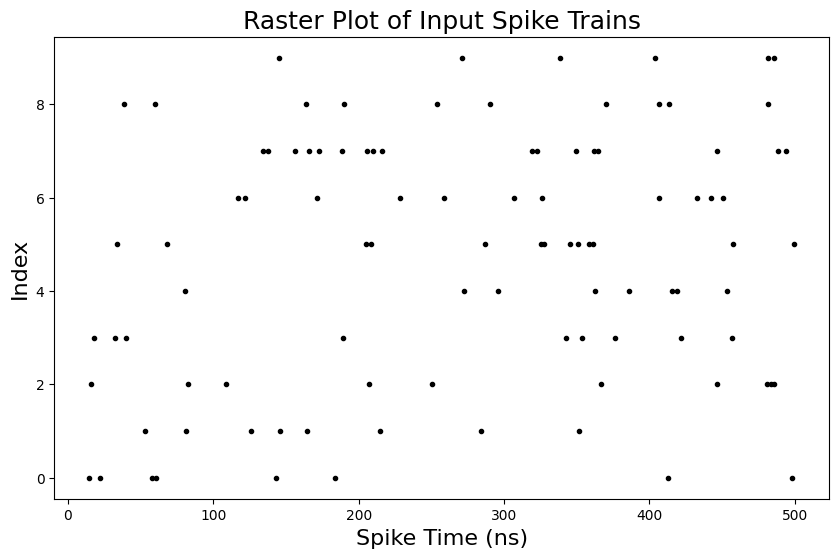

In [3]:
# random spike train for one input channel with ten spikes total over 100ns
input = SuperInput(channels=10, type='random', total_spikes=100, duration=500)
raster_plot(input.spike_arrays, title='Raster Plot of Input Spike Trains')

 - Adding the input to a neuron can be done with node methods
   - `uniform_input`: add a given spike train to all available synapses
   - `custom_input`: add a given spike train to specific synapses
   - `multi_channel_input`: define specific connectivity between multiple inputs and multiple synapses

In [4]:
# information about classes, methods, and functions can always be printed via
print(SuperNode.uniform_input.__doc__)


        uniform_input:
         - syntax -> SuperNode.uniform_input(SuperInput)
         - Adds the same input channel to all available synapses
         - note, the first channel of the SuperInput object will be used
        


### Simulation
- An input event creates a jump in current in the SPD synapse loop
- This causes flux to be coupled into the associated dendrite
  - In the case below, we are still using the default monosynaptic point neuron
  - Thus, the SPD synapse feeds into the somatic dendrite directly
- Because here the coupling strength between the synapse and soma is 1 (by default), the shape of the SPD flux resposne can be observed as the plotted $\phi_r$ curve (flux recieved by the soma from the synapse)
-  ***Signal*** (a term from spin glass literature, but think ***membrane potential***) is integrated into the soma according to received flux
   -  The transfer function is non-trivial (though it appears so here) --> we will explore this later 

Generating defined input...


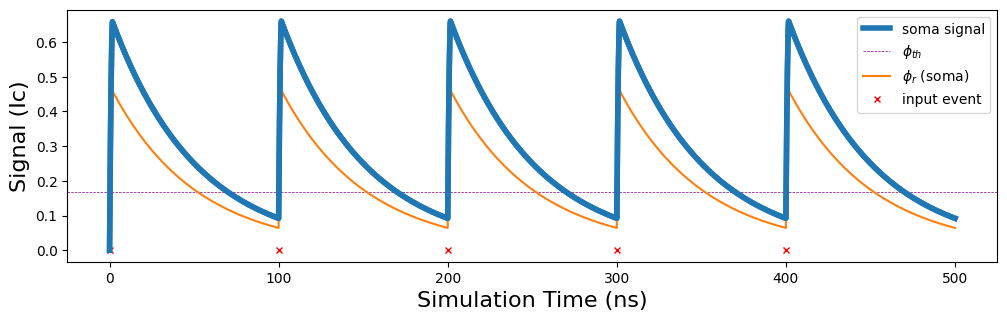

In [5]:
spike_times = np.arange(0,500,100) # spike times in nanoseconds

# if type=='defined': defined_spikes argument create 1-channel input object
input = SuperInput(type='defined', defined_spikes=spike_times)

# note, any neuron or dendrite parameters can be passed into the node class init
node = SuperNode(s_th=100) # large spiking threshold to avoid spiking for now

# adding input uniformly to available synapse on node's neuron
# in this case there is only one synapse attached to the somatic dendrite
node.uniform_input(input)

# create and simulate a (single node) network
net = network(
    sim=True,           # run simulation
    dt=.1,              # time step (ns)
    tf=input.duration,  # total duration (ns)
    nodes=[node]        # nodes in network to simulate
    )       

# plot neuron activity
node.plot_neuron_activity(net,spikes=True,phir=True,input=input)


***Exercise!***
  - (1.1) Run the simulation a few times (random input spike trains will be generated each time)
    - Estimate the maximum frequency a synapse can recieve a new input event


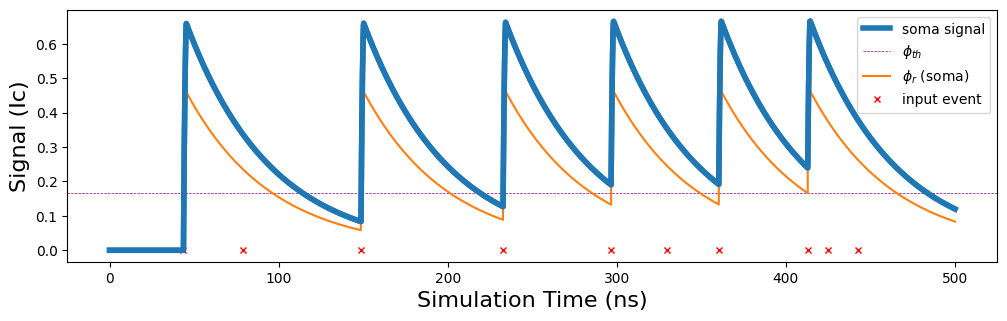

In [6]:
# random spike train for one input channel with ten spikes total over 100ns
input = SuperInput(channels=1, type='random', total_spikes=10, duration=500)

node = SuperNode(s_th=100)
node.uniform_input(input)
net = network(sim=True,dt=.1,tf=500,nodes=[node])
node.plot_neuron_activity(net,spikes=True,phir=True,input=input)

### Parameters

***Exercise!***
 - 1.2 Play with the below node parameters 
   - In this case, these are somatic dendrite params (denoted by _ni suffix)
 - 1.3 Attempt to get zero,five, and ten output spikes for your random input spike train!
   - Best done with combinatinos of change, but can be done with any one of these parameters while holding the rest constant!
 - 1.4 Try to define the influence of each parameter
 - 1.5 Understand the role of the red line (refractory dendrite signal)

*Hint --> See subsequent information slide*

Generating defined input...


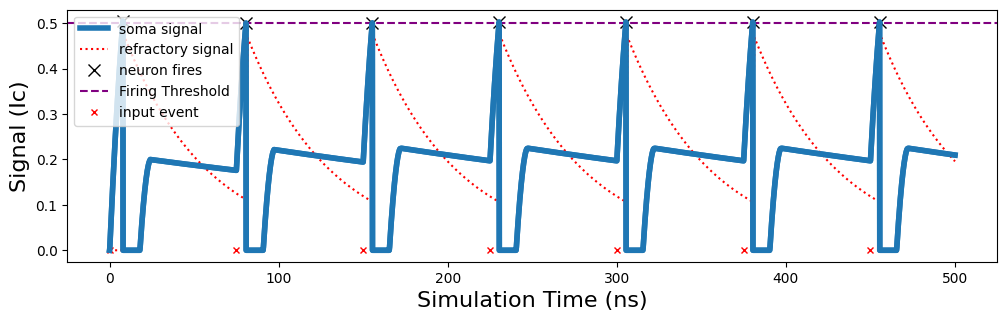

In [7]:
spike_times = np.arange(0,500,75)
input = SuperInput(type='defined', defined_spikes=spike_times)

node = SuperNode(
    s_th    = .5,          # spiking threshold    (you choose)
    ib_n    = 2.05,         # bias current         (realistically, must be between 1.4 and 2.05)
    tau_ni  = 400,          # time constant        (and positive value)
    beta_ni = 2*np.pi*1e3,  # inductance parameter (just change the exponent)
    ) 

node.uniform_input(input)
net = network(sim=True,dt=.1,tf=500,nodes=[node])
node.plot_neuron_activity(net,ref=True,spikes=True,input=input)

While there are many fabrication determined physical constants associated with a SOEN neuron, there are only three main dendritic parameters for moderating computation:
 - $i_b$ = `ib`   = bias current (determines how much signal can be integrated into a dendrite, and strength of integration for a given amount of recieved flux)
 - $\tau$ = `tau`  = the time constant by which integrated signal can be leaked
 - $\beta$ = `beta` = determines inductor size in the integration loop (and therefore shape of integration curve)

These parameters influence signal integration for any given dendrite according to:
\begin{equation*}
\beta \frac{ds}{dt} = r(\phi,s,i_b)) - \alpha s
\end{equation*}

which is implemented in the code via the forward euler method as:
\begin{equation*}
s_{t+1} = s_t(1-\Delta t\frac{\alpha}{\beta}+\frac{\Delta t}{\beta} r(\phi,s,i_b))
\end{equation*}

Note that all dendrites have these parameters and all dendrites integrate signal.  We use the `_ni` suffix for the somatic dendrite specifically and the `_di` for all arbor dendrites.

The rate array function $r(\phi,s,i_b)$ refers to a pre-derived three-dimensional surface defined by: 
 - $s$ = accumulated signal in the dendritic integreation loop at the previous time step
 - $\phi_r$ =  received flux via couplings into the dendritic recieving loop
 - $r_{fq}$ = flux quantum production (fluxons emmitted from receiving loop to integration loop)

`s` and `phi_r` are used to reference `r_fq`, which determines new signal to be accumulated (via fluxons) into the dendritic integration loop.  Refering to the below plot, we see that for greater values of $s$, there is less flux quantum production for the same received flux $\phi_r$.  This is because the loop approaches *saturation*.


We also see that for different values of $i_b$, greater $r_{fq}$ values can be achieved for equivalent $s$ and $\phi_r$ values because the saturation limit is rasied.

![ title](../img/rate_arrays.png)

### Saturation
***Exercise!***
 - (1.5) Run the code below and observe that signal integration approaches a limit.  Is this a balance of input/decay rate or true signal saturation.  What parameter can be changed to know the difference?
   - **hint -> We want to be sure that the signal is not simply leaking at about the same frequency that is being integrated*

Generating defined input...


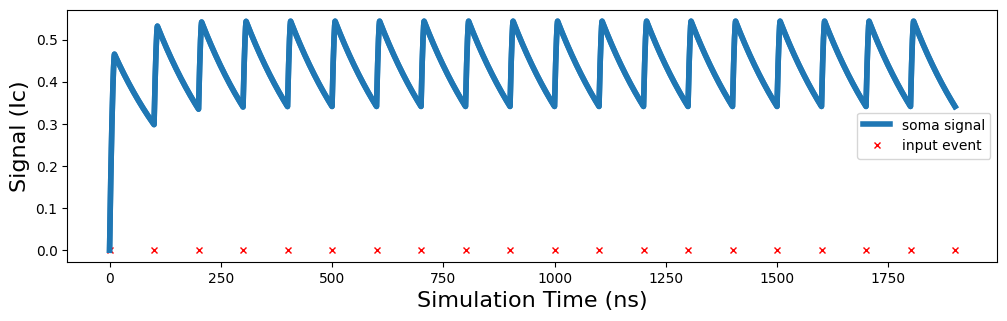

In [8]:
spike_times = np.arange(0,2000,100)
input = SuperInput(channels=1, type='defined', defined_spikes=spike_times, duration=np.max(spike_times))

node = SuperNode(
    s_th    = 100,          # spiking threshold    
    ib_n    = 1.8,          # bias current         
    tau_ni  = 200,          # time constant #**10
    beta_ni = 2*np.pi*1e3,  # inductance parameter
    ) 

# all (there's only one) synapses get the same input
node.uniform_input(input)

# create and simulate (single neuron) network
net = network(sim=True,dt=.1,tf=np.max(spike_times),nodes=[node])

# plot activity
node.plot_neuron_activity(net,spikes=True,input=input)

### Rollover
- `w_sd` = coupling strength between synapse and dendrite (in this case the somatic dendrite)

***Exercise!***
 - (1.6) Analyize the following plot and then run the code.  Given our new parameter, signal integration may not behave as expected.  Can you explain why? (y-axis = r_fq and x-axis = phi_r, *make better plot)
 - (1.7) Play around with different values of ib_n and w_sd.  Pay attention to the $\phi_{th}$ line.  What does it demarcate?

![ title](../img/phi_period.png)

Generating defined input...


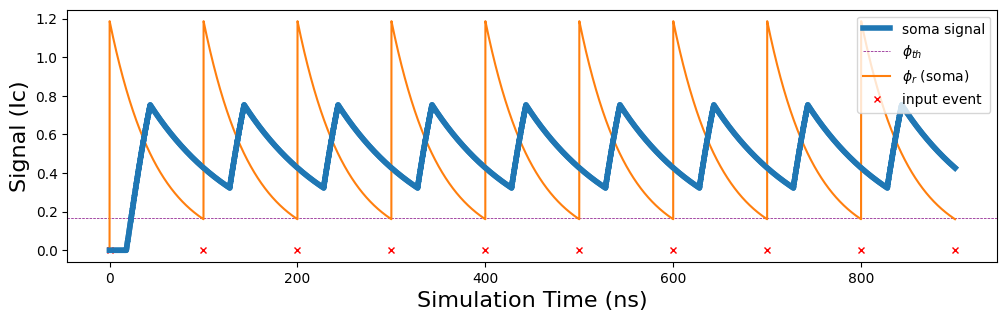

In [9]:
spike_times = np.arange(0,1000,100)
input = SuperInput(channels=1, type='defined', defined_spikes=spike_times, duration=np.max(spike_times))

node = SuperNode(
    s_th    = 100,          # spiking threshold    (you choose)
    ib_n    = 1.8,          # bias current         (must be between 1.4 and 2.05)
    tau_ni  = 100,          # time constant        (and positive value)
    beta_ni = 2*np.pi*1e2,  # inductance parameter (just change the exponent)
    w_sd=2.5,               # determines coupling strength of synapse to dendrite
    ) 

node.uniform_input(input)
net = network(sim=True,dt=.1,tf=np.max(spike_times),nodes=[node])
node.plot_neuron_activity(net,spikes=True,input=input,phir=True,ref=False)

## Part 2: Dendritic Arbors
 - Biological neurons are much more than soma and a synapse!
 - SOEN neurons therefore incorporate potentially large dendrite structures
 - This allows for complex computations to occur at the single neuron level!

### Building Structure
 - Using `SuperNode`, arbitrary dendritic trees (or arbors) can be built
 - Simply pass in a `weights` argument and a dendritic tree will be built with this shape
 - Each value in `weights` determines the coupling strength of that connection

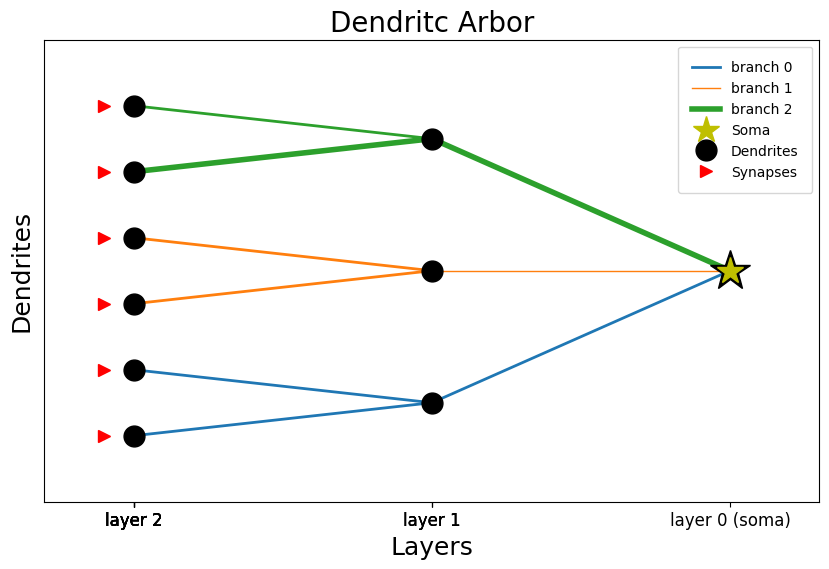

In [10]:
weights = [
    [[0.4,.3,.8]],
    [[.5,.5],[.5,.5],[.9,.5]]
    ]
node = SuperNode(weights=weights)
node.plot_structure()

### Synaptic Structure
 - Mostly, we would like to simply use the default synaptic layer at the outermost dendrite of the tree
 - However, if custom synaptic structure are desired, a list of arbor structure (now including one extra preceding layer for the soma) can be included to define synapse locations.  One structure per synapse.

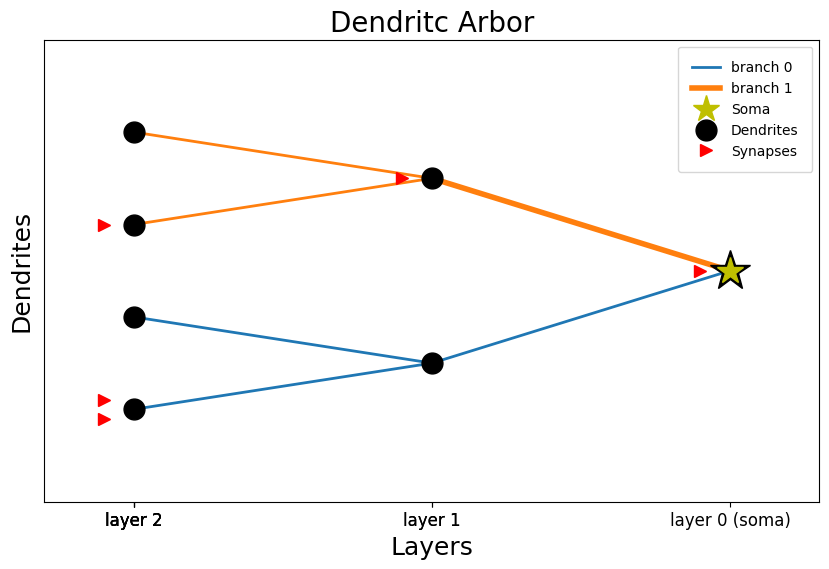

In [11]:
weights = [
    [[0.4,.8]],
    [[.5,.5],[.5,.5]]
    ]

syn_struct = [

    [[[0]],
    [[0,0]],
    [[1,0],[0,0]]],

    [[[0]],
    [[0,0]],
    [[1,0],[0,0]]],

    [[[0]],
    [[0,0]],
    [[0,0],[1,0]]],

    [[[0]],
    [[0,1]],
    [[0,0],[0,0]]],

    [[[1]],
    [[0,0]],
    [[0,0],[0,0]]],

]

node = SuperNode(weights=weights,synaptic_structure=syn_struct)
node.plot_structure()

Generating defined input...


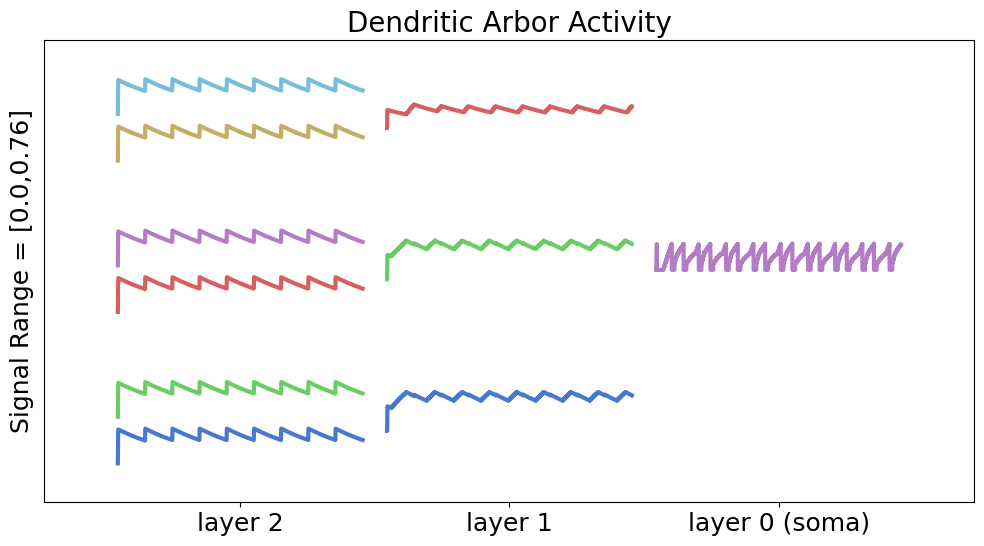

In [12]:
spike_times = np.arange(0,1000,100)
input = SuperInput(channels=1, type='defined', defined_spikes=spike_times, duration=np.max(spike_times))
weights = [
    [[0.4,.3,.2]],
    [[.5,.5],[.5,.5],[.9,.5]]
    ]
node = SuperNode(weights=weights)
node.uniform_input(input)
net = network(sim=True,dt=.1,tf=np.max(spike_times),nodes=[node])
node.plot_arbor_activity(net)

### Part 3: Computing with A Single Neuron
***Exercise!***
 - (3.1) Try inventing an AND gate such that the neuron only fires when receiving input at both synapses simultaneously
 - (3.2) Now try inventing the XOR gate! **Hint*, you will have to apply the concepts of inhibiton, refraction, and negative spikes to do this cleanly (one spike per truth value).

Generating defined input...
Output spike times:  [ 52. 502.]


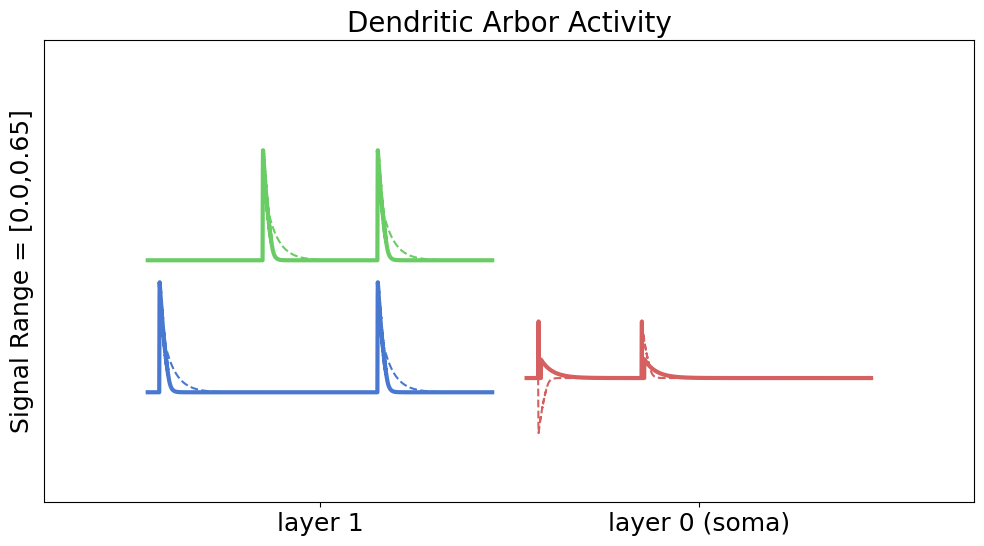

In [13]:
times = [50,500,1000,1000]
indices = [0,1,0,1]
def_spikes = [indices,times]
input = SuperInput(channels=2, type='defined', defined_spikes=def_spikes, duration=400)
# from soen_plotting import raster_plot
# raster_plot(input.spike_arrays)

# weights = [
#     [[0.4,.4]],
#     ]
# taus = [
#     [[10,10]],
#     ]
weights = [
    [[-.5,.5]],
    ]
taus = [
    [[10,10]],
    ]

connect = [[0,0],[1,1]]


# synaptic layer automatically draped over outer-most dendrites
node = SuperNode(s_th=.33,weights=weights,taus=taus,ib_ref=1)
node.multi_channel_input(input,connect)
net = network(sim=True,dt=.1,tf=1500,nodes=[node])
print("Output spike times: ",net.spikes[1])
# node.plot_neuron_activity(net,phir=True,legend=True) # useful for XOR
node.plot_arbor_activity(net,phir=True)

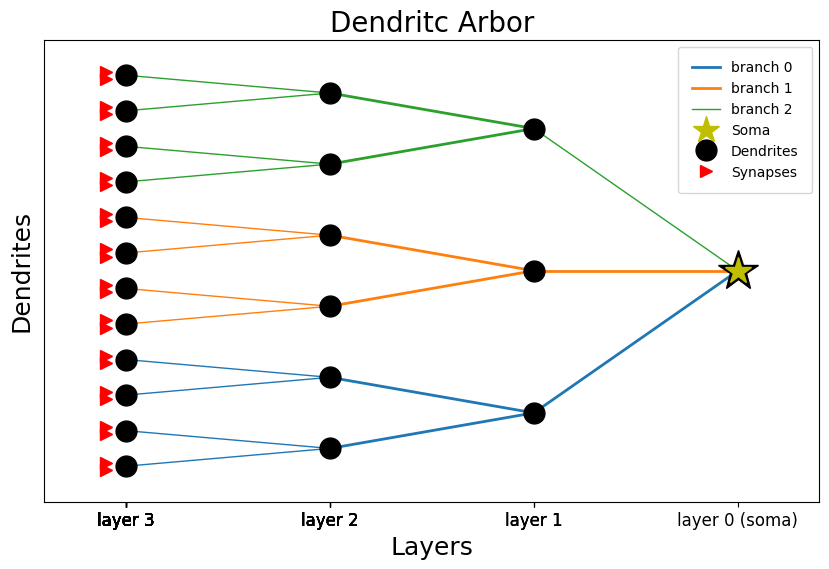

In [14]:
from sim_soens.soen_utilities import dend_load_arrays_thresholds_saturations

# load backend dendrite parameters
d_params_ri = dend_load_arrays_thresholds_saturations('default_ri')
d_params_rtti = dend_load_arrays_thresholds_saturations('default_rtti')

# use bias current from the values for which rate arrays have been generated
ib__list__ri = d_params_ri['ib__list']
ib__list__rtti = d_params_rtti['ib__list']

params = {
    'weights': [
        [[.5,.4,.3]],
        [[0.5,0.5],[0.5,0.5],[0.5,0.5]],
        [[0.35,-0.65],[0.35,-0.65],[0.35,-0.65],[0.35,-0.65],[0.35,-0.65],[0.35,-0.65]]
    ],
    'taus': [
        [[10,150,1000]],
        [[250,250],[250,250],[250,250]],
        [[250,250],[250,250],[250,250],[250,250],[250,250],[250,250]]
    ],

    'biases': [
        [[3,3,3]],
        [[5,5],[5,5],[5,5]],
        [[-4,3],[-4,3],[-4,3],[-4,3],[-4,3],[-4,3]]
    ],
    'types': [
        [['rtti','rtti','rtti']],
        [['ri','ri'],['ri','ri'],['ri','ri']],
        [['rtti','ri'],['rtti','ri'],['rtti','ri'],['rtti','ri'],['rtti','ri'],['rtti','ri']]
    ],
    'syns': [['2','5'],['4','6'],['5','8'],['4','6'],['1','3'],['7','9'],
             ['4','6'],['2','5'],['7','9'],['1','3'],['4','6'],['5','8']],
    'syn_w': [[.6,.6],[.5,.5],[.6,.6],[.5,.5],[.6,.6],[.5,.5],
              [.6,.6],[.5,.5],[.6,.6],[.5,.5],[.6,.6],[.5,.5]],
       
    # "ib_ne": ib__list__ri[4],
    "tau_di": 250,
    "ib_n": ib__list__ri[4], 
    "beta_ni": 2*np.pi*1e2,
    "tau_ni": 50,
    "w_sd": 1,
    "ib_ref": ib__list__ri[8], 
    "beta_ref": 2*np.pi*1e2,
    "tau_ref": 50,
    'ib_list_ri':ib__list__ri[:],
    'ib_list_rtti':ib__list__rtti[:],
}

# create a neuron with this structure and parameters
nine_neuron = SuperNode(s_th=.1,**params) 
nine_neuron.plot_structure()

Generating defined input...
Generating defined input...
Generating defined input...


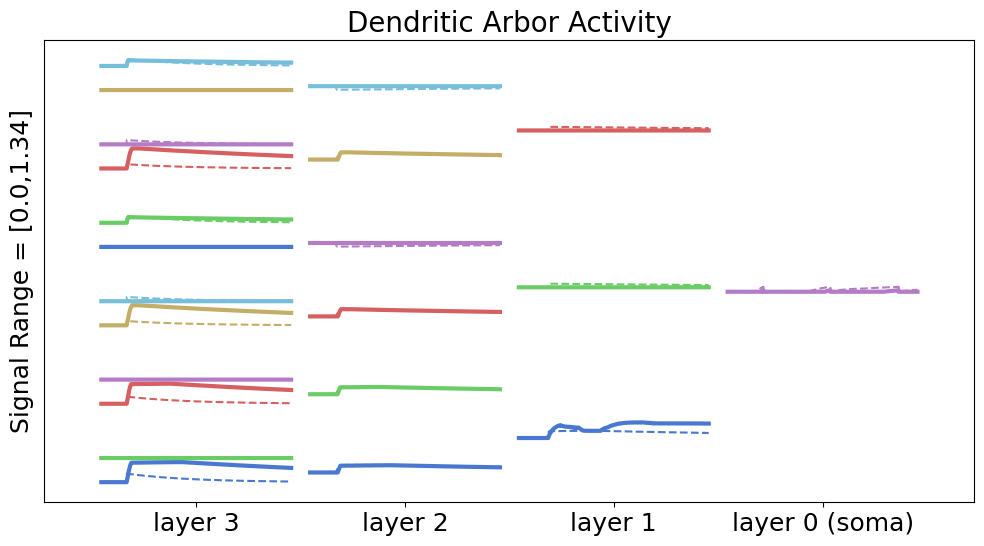

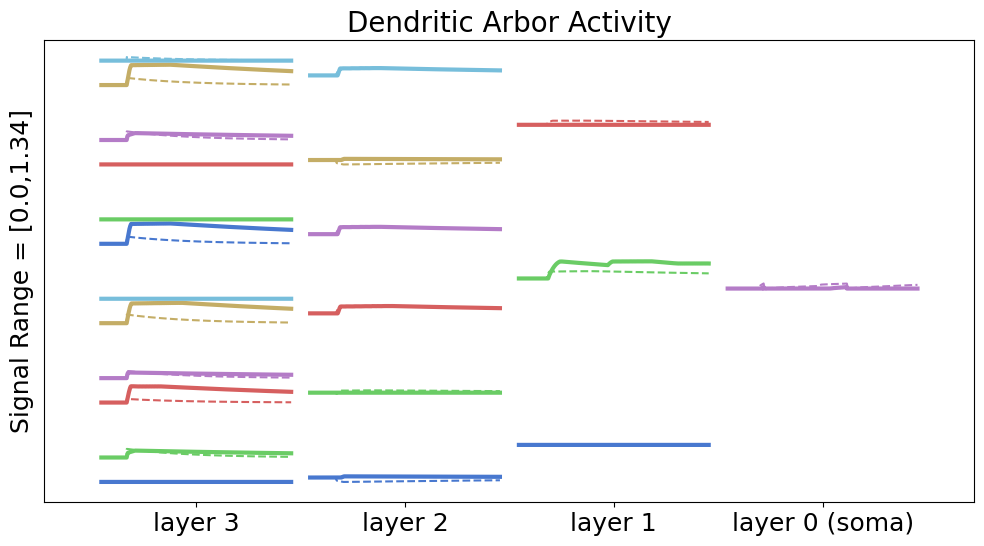

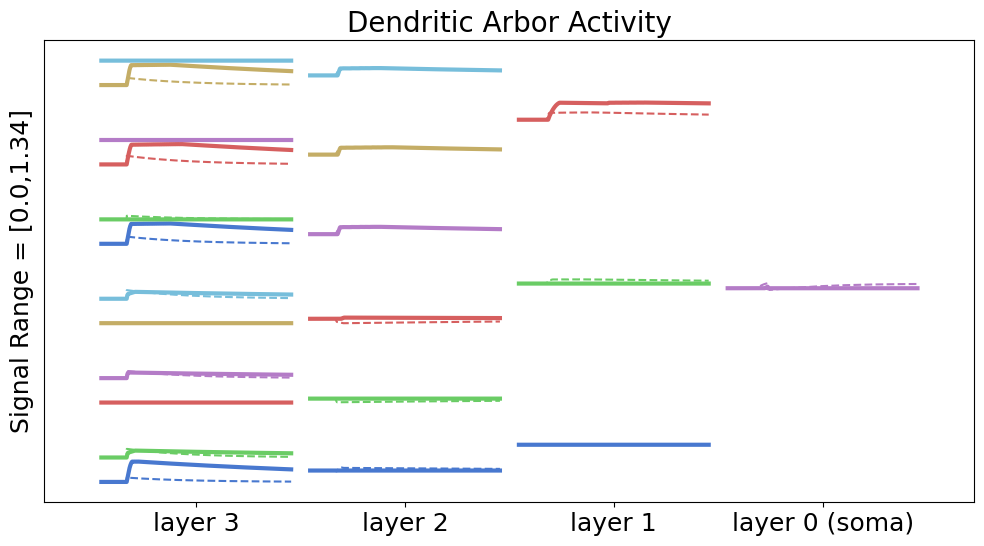

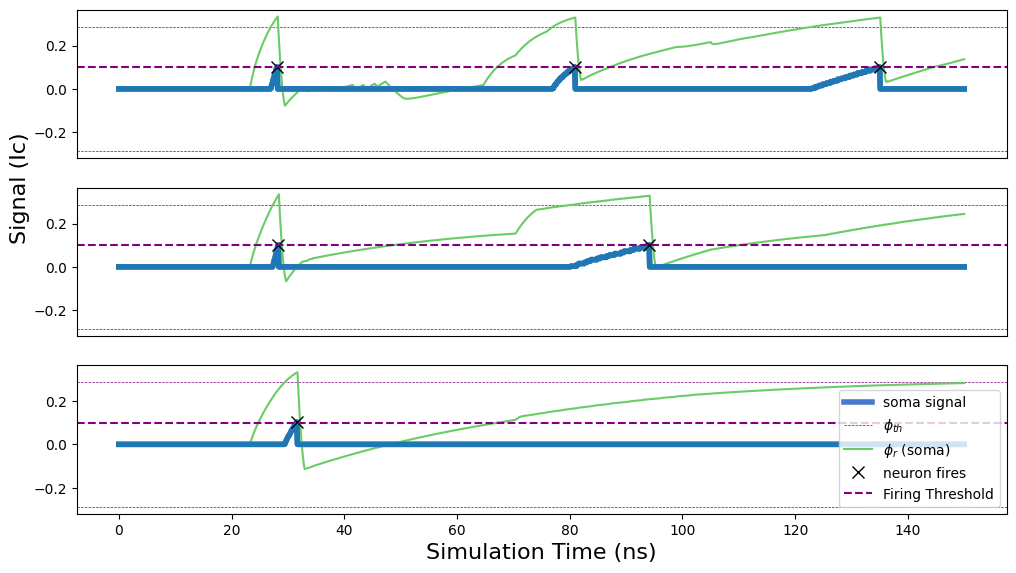

In [15]:

z = np.array([0,1,4,7,8]) # z-pixel array
v = np.array([1,4,3,6,8])-1 # v
n = np.array([2,4,6,7,9])-1 # n
letters = [z,v,n]

run_neurons = []

for let in letters:
    nine_neuron = SuperNode(s_th=.1,**params) 
    indices = let
    times = np.ones(len(indices))*20
    def_spikes = [indices,times]
    input = SuperInput(channels=9, type='defined', defined_spikes=def_spikes, duration=100)
    # raster_plot(input.spike_arrays)
    count = 0
    for g in nine_neuron.synapses:
        for s in g:
            for i,row in enumerate(input.spike_rows):
                if i == int(s.name)-1:
                    s.add_input(input.signals[i])
                    count+=1
    run_neurons.append(nine_neuron)

net = network(sim=True,dt=.1,tf=150,nodes=run_neurons,new_way=True)

for n in run_neurons:
    n.plot_arbor_activity(net,phir=True)

activity_plot(run_neurons,net,dend=False,phir=True,size=(12,8))

### Part 5: Networking and Dynamics
 - Network demo with computation example!

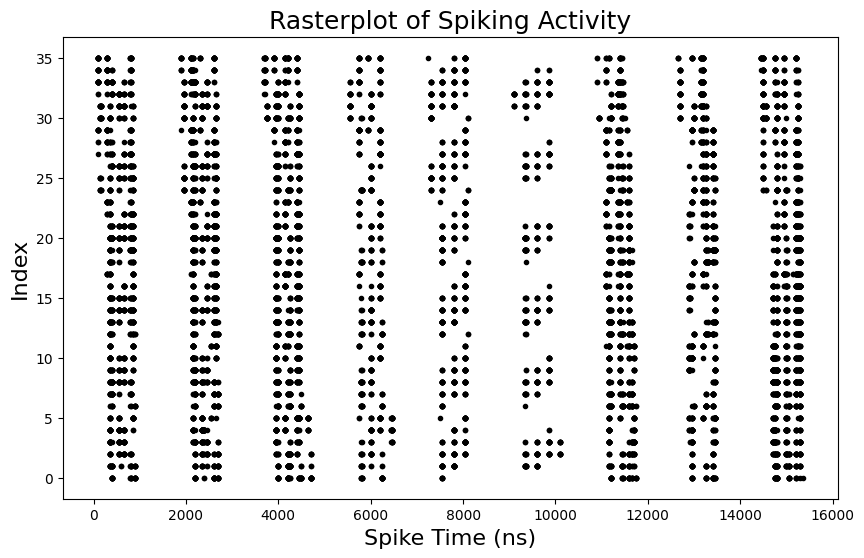

In [40]:
from sim_soens.super_net import PointReservoir
input = SuperInput(channels=36,type="saccade_MNIST",tile_time=50)
raster_plot(input.spike_arrays)

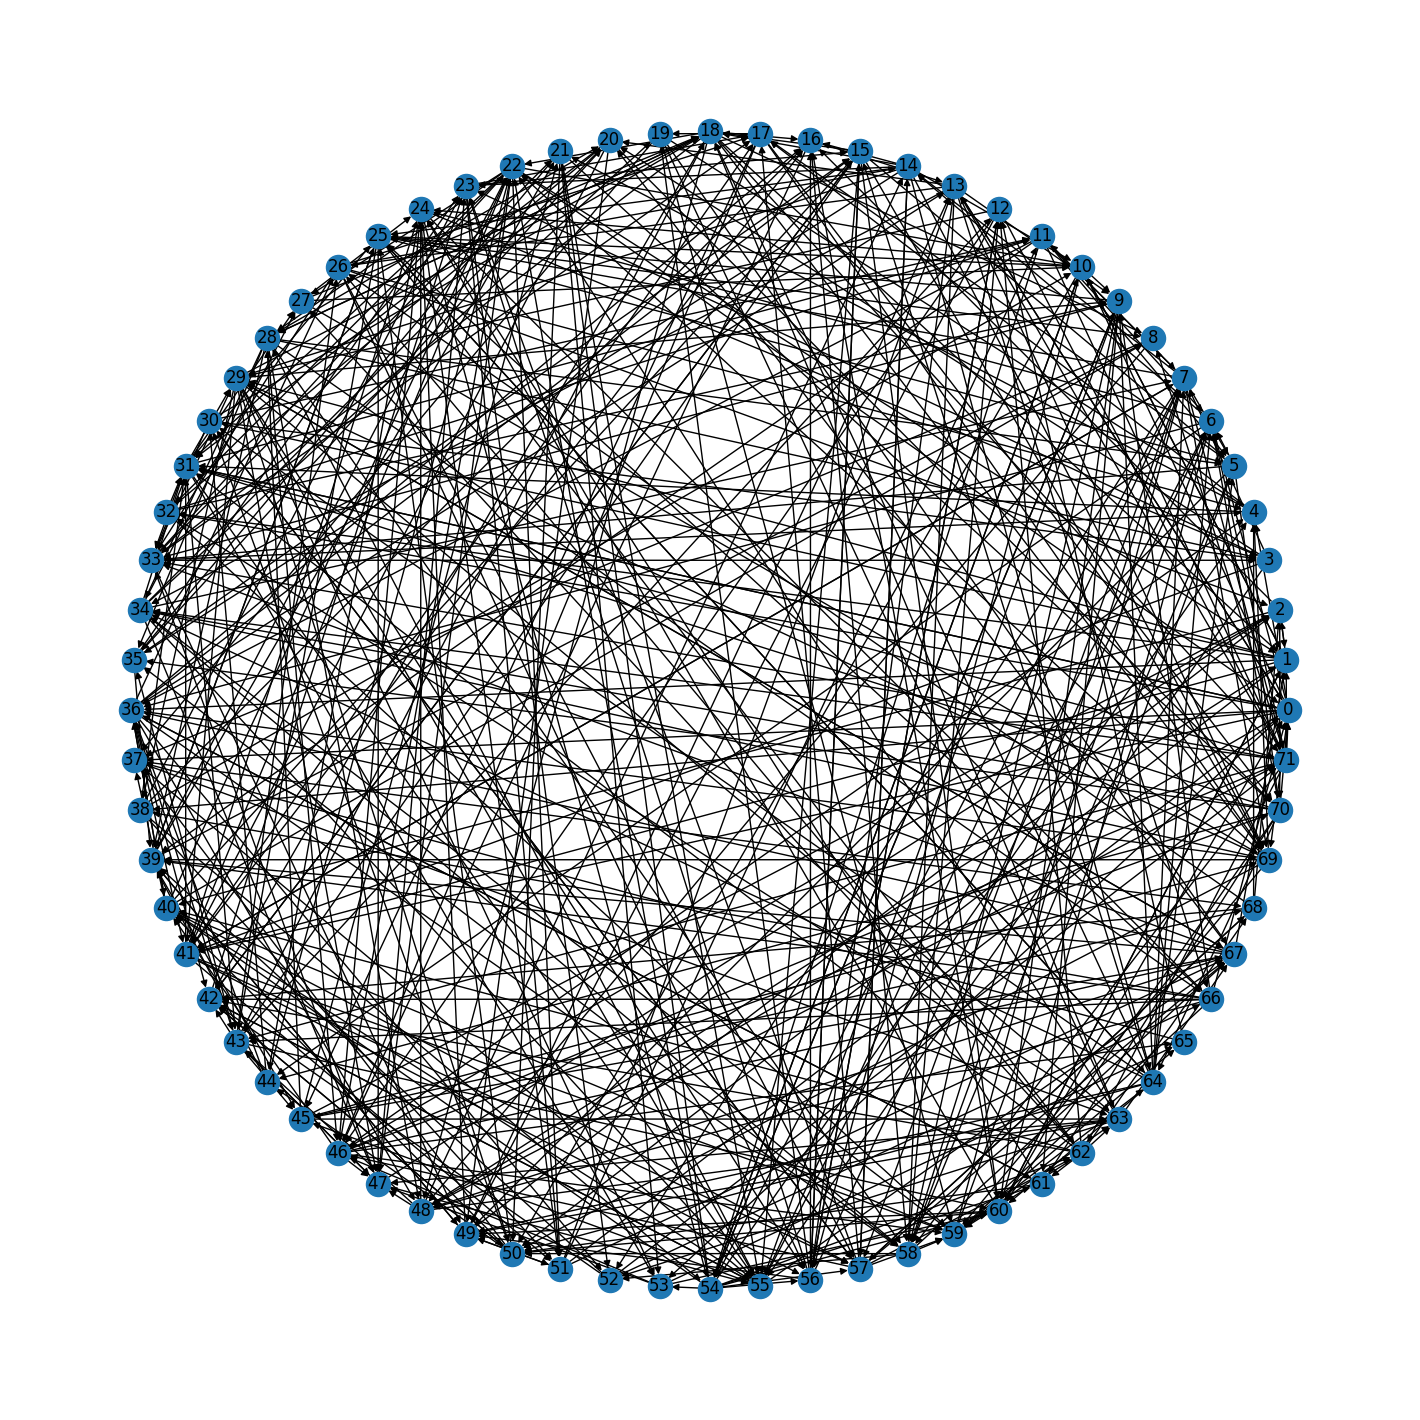

In [45]:
# Reservoir params
params= {
    "N":72,
    "s_th":0.5,
    "beta":2*np.pi*10**2,
    "tau":100,
    "tau_ref":50,
    "tf":3600*5,
    "run":1,
    "laps":10,
    }

res = PointReservoir(**params)
res.graph_net()

In [46]:

res.connect_input(input)
# res.graph_input()

running network


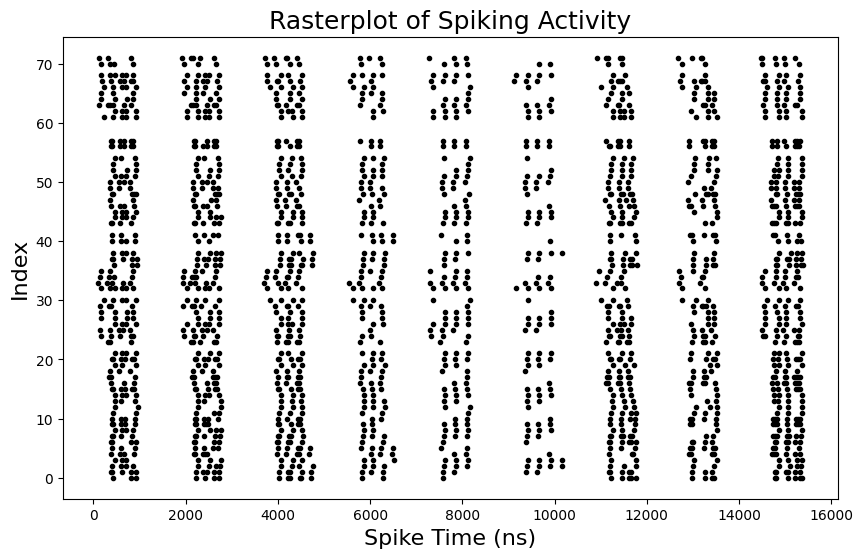

In [47]:
res.run_network()
raster_plot(res.net.spikes)

[0 1 2]  --> Classified!


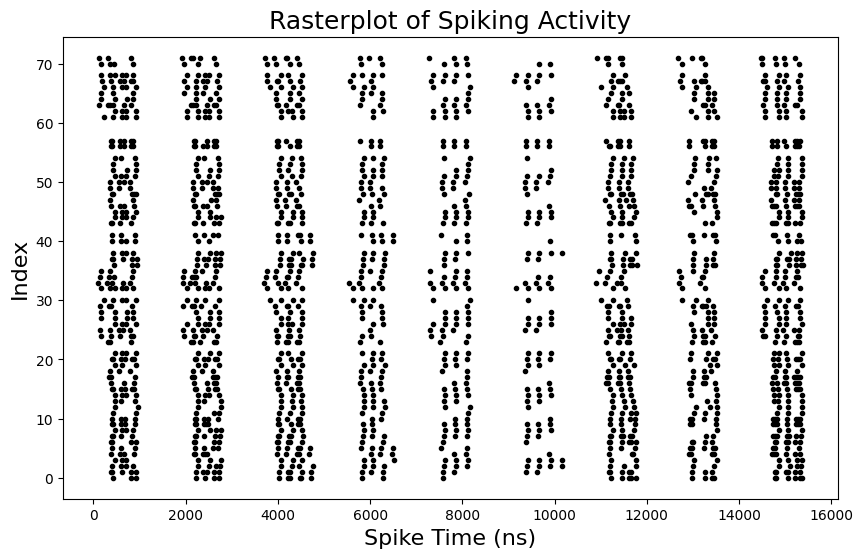

In [53]:
from sim_soens.super_functions import *
from sklearn.linear_model import LogisticRegression
spikes = res.net.spikes
# spikes = input.spike_arrays

N = 72
T = 3601*5
classes = 3
examples_per_class = 3
samples = classes*examples_per_class
window = 360*5
labels = [0,0,0,1,1,1,2,2,2]

# spikes = net.net.spikes
mat = spks_to_binmatrix(N,T,spikes)
# raster_plot(spikes)
model = LogisticRegression(max_iter=100000)
model_fine = LogisticRegression(max_iter=100000)
X = []
y = []
X_f = []
y_f = []
for i in range(samples):
    if  i%3 != 2:
        section = mat[:,i*window:i*window+window]
        x = np.concatenate(section).reshape(1, -1)[0]
        X.append(x)
        y.append(labels[i])


model.fit(X,y)

X_test = []
y_test = []
for i in range(samples):
    if i%3 == 2:
        section = mat[:,i*window:i*window+window]
        x = np.concatenate(section).reshape(1, -1)[0]
        X_test.append(x)


predictions=model.predict(X_test)

if np.array_equal(predictions, [0,1,2]):
    print(predictions, " --> Classified!")
    raster_plot(spikes)
else:
    print(predictions)